<a href="https://colab.research.google.com/github/girishmahale786/NLP-Lab/blob/main/Assignment1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fake News Classification on WELFake Dataset


Name: Girish Mahale  
PRN: 23070126504  
Batch: AI-ML B3

## Dataset Description

(WELFake) is a dataset of 72,134 news articles with 35,028 real and 37,106 fake news. For this, authors merged four popular news datasets (i.e. Kaggle, McIntire, Reuters, BuzzFeed Political) to prevent over-fitting of classifiers and to provide more text data for better ML training.

Dataset contains four columns: Serial number (starting from 0); Title (about the text news heading); Text (about the news content); and Label (0 = fake and 1 = real).

There are 78098 data entries in csv file out of which only 72134 entries are accessed as per the data frame.

In [ ]:
# Mounting the google drive for loading the dataset
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Importing necessary libraries
import re
import nltk
from nltk.tag import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

In [ ]:
# Downloading nltk_data
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_eng to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_ru.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_rus to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |  

True

In [ ]:
# Loading the dataset (stored in google drive)
df = pd.read_csv('/content/drive/MyDrive/WELFake_Dataset.csv', index_col=0)
df.head()

,title,text,label
0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,NaN,Did they post their votes for Hillary already?,1
2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1


In [ ]:
# Removing null values and duplicates, also only using title for the prediction
del df["text"]
df.dropna(inplace=True)
df.drop_duplicates(inplace=True)
df.reset_index(drop=True, inplace=True)
df.head()

,title,label
0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,1
1,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,1
2,"Bobby Jindal, raised Hindu, uses story of Chri...",0
3,SATAN 2: Russia unvelis an image of its terrif...,1
4,About Time! Christian Group Sues Amazon and SP...,1


In [ ]:
# Function to convert nltk pos tags to wordnet pos tags
def wn_pos(tag):
    valid_pos = ["n", "v", "a", "r", "s"]
    pos = tag.lower()[0]
    if pos not in valid_pos:
        return "n"
    return pos

# Function to clean and preprocess the text
def clean_text(text):
    text = re.sub(r'http://\S+|https://\S+', '', text)  # Remove URLs
    text = re.sub(r'[^\w\s]', '', text)  # Remove symbols
    text = text.lower()  # Convert to lowercase
    text = text.strip() # Remove Whitespace

    # Tokenization
    tokens = word_tokenize(text)

    # POS tagging
    pos_tags = pos_tag(tokens)

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token, wn_pos(tag)) for token, tag in pos_tags]

    # Remove stopwords
    text = " ".join([word for word in tokens if word not in stopwords.words('english')])
    return text

# Applying preprocessing to the 'title' column
df["cleaned_title"] = df["title"].apply(clean_text)
df.head()

,title,label,cleaned_title
0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,1,law enforcement high alert follow threat cop w...
1,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,1,unbelievable obamas attorney general say charl...
2,"Bobby Jindal, raised Hindu, uses story of Chri...",0,bobby jindal raise hindu us story christian co...
3,SATAN 2: Russia unvelis an image of its terrif...,1,satan 2 russia unvelis image terrify new super...
4,About Time! Christian Group Sues Amazon and SP...,1,time christian group sue amazon splc designati...


In [ ]:
# Function to train different models with different vectorizors
def train_model(model, vectorizer, df):
    X = vectorizer.fit_transform(df['cleaned_title'])
    X_scaled = StandardScaler(with_mean=False).fit_transform(X)
    y = df['label']
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, stratify=y, test_size=0.2, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return y_test, y_pred, str(model), str(vectorizer)


# Function to get the metrics of the trained model
def get_metrics(model, vectorizer, df):
    y_test, y_pred, model, vectorizer = train_model(model, vectorizer, df)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    return  model, vectorizer, accuracy, precision, recall, f1

In [ ]:
# Dataframe to store the metrics of different models
metrics = pd.DataFrame(columns=['Model', 'Vectorizer', 'Accuracy', 'Precision', 'Recall', 'F1-Score'])

# Storing the metrics of different models
metrics.loc[0] = get_metrics(LogisticRegression(), CountVectorizer(), df)
metrics.loc[1] = get_metrics(LogisticRegression(), TfidfVectorizer(), df)
metrics.loc[2] = get_metrics(SVC(), CountVectorizer(), df)
metrics.loc[3] = get_metrics(SVC(), TfidfVectorizer(), df)
metrics.loc[4] = get_metrics(RandomForestClassifier(), CountVectorizer(), df)
metrics.loc[5] = get_metrics(RandomForestClassifier(), TfidfVectorizer(), df)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

In [ ]:
# The metrics are sorted by highest accuracy
metrics.sort_values(by='Accuracy', ascending=False)

,Model,Vectorizer,Accuracy,Precision,Recall,F1-Score
5,RandomForestClassifier(),TfidfVectorizer(),0.885334,0.872337,0.871712,0.872024
4,RandomForestClassifier(),CountVectorizer(),0.880122,0.870297,0.860798,0.865521
0,LogisticRegression(),CountVectorizer(),0.831850,0.817801,0.803901,0.810791
1,LogisticRegression(),TfidfVectorizer(),0.828402,0.815323,0.797817,0.806475
3,SVC(),TfidfVectorizer(),0.820143,0.767338,0.859188,0.810669
2,SVC(),CountVectorizer(),0.819261,0.770391,0.850063,0.808268


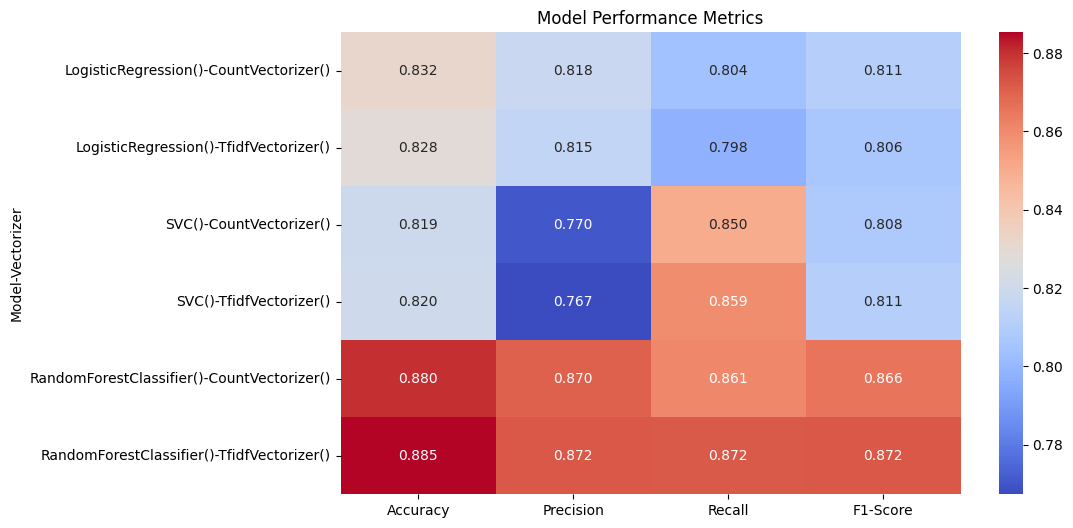

In [ ]:
# Setiing 'Model' and 'Vectorizer' as the index
metrics.set_index(['Model', 'Vectorizer'], inplace=True)

# Creating a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(metrics, annot=True, cmap='coolwarm', fmt='.3f')
plt.title('Model Performance Metrics')
plt.show()